In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### **API 키 설정**

#### **필요 라이브러리 호출**

In [1]:
from typing import List, Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel

#### **프롬프트 작성을 위한 정보 수집 함수 정의하기**

In [2]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

#### **프롬프트 작성 함수 정의하기**

In [3]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
            print(tool_call)
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

#### **프롬프트 구성에 필요한 정보 수집을 완료하기 위한 edge 로직**

In [4]:
from typing import Literal
from langgraph.graph import END

def get_state(state) -> Literal["prompt", "info", "__end__"]:
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "prompt"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

#### **그래프 구축하기**

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)

# 엣지 및 조건부 엣지 추가
workflow.add_conditional_edges("info", get_state)
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)

#### **그래프 시각화**

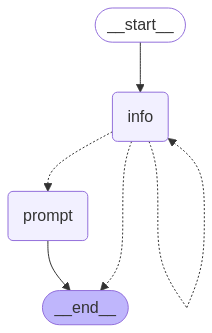

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### **그래프 실행**

In [7]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

================================== Ai Message ==================================

Hello! How can I assist you today? Are you looking to create a prompt template? If so, please provide me with the following information:

1. What is the objective of the prompt?
2. What variables will be passed into the prompt template?
3. Are there any constraints for what the output should NOT do?
4. Are there any requirements that the output MUST adhere to? 

Feel free to share any details you have!
================================== Ai Message ==================================

If you need assistance or have any questions in the future, feel free to reach out. Have a great day!
AI: Byebye
